In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import chi2, SelectKBest, RFECV, SelectFromModel, SequentialFeatureSelector
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from pdpbox import pdp, get_dataset, info_plots

In [2]:
df = pd.read_csv('caravan.csv')

One-hot-encode categorical features
- which features are categorical was derived from the feature description in the assignment

In [3]:
cat_cols = ['Customer Subtype', 'Customer main type', 'Roman catholic', 'Contribution private third party insurance']
df[cat_cols] = df[cat_cols].astype(object)
df = pd.get_dummies(df)

In [4]:
y = df['CARAVAN POLICY']
X = df.drop('CARAVAN POLICY', axis=1)

In [5]:
df['CARAVAN POLICY'].value_counts()


0    5474
1     348
Name: CARAVAN POLICY, dtype: int64

As can be seen the whole dataset is very imbalanced. Therefore accuracy is not that good a metric to decide the goodness of the classifier. Instead I'll use the f1_weighted as the scoring metric.

In [6]:
seq_feat = SequentialFeatureSelector(estimator=DecisionTreeClassifier(), n_features_to_select=10, cv=None, n_jobs=-1)
seq_feat.fit(X, y)
X_new = seq_feat.fit_transform(X,y)

X_new = pd.DataFrame(X_new, columns=seq_feat.get_feature_names_out())

In [7]:
param_grid = dict(C = np.logspace(-4,4,10))
clf = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid=param_grid, n_jobs=-1, scoring='f1_weighted')
clf.fit(X_new, y)
clf = clf.best_estimator_
y_pred = clf.predict(X_new)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.60      0.74      5474
           1       0.08      0.55      0.14       348

    accuracy                           0.60      5822
   macro avg       0.52      0.58      0.44      5822
weighted avg       0.90      0.60      0.70      5822



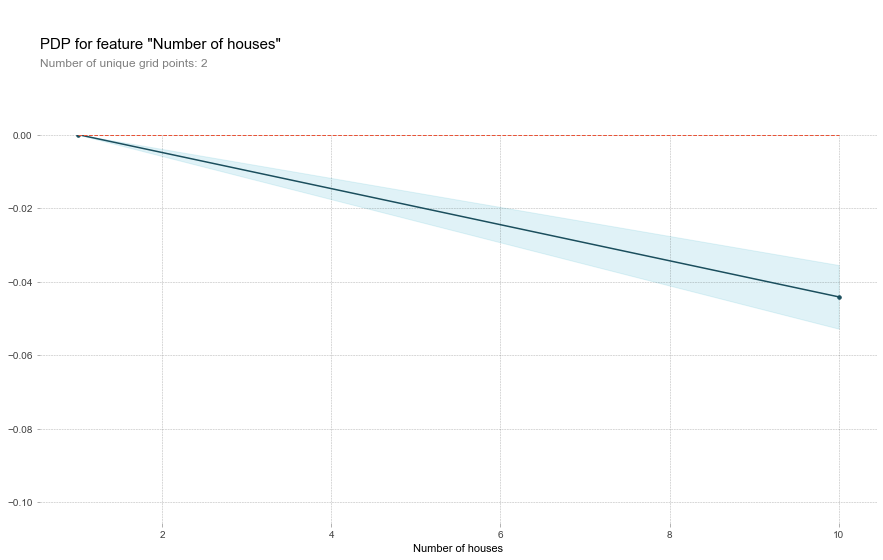

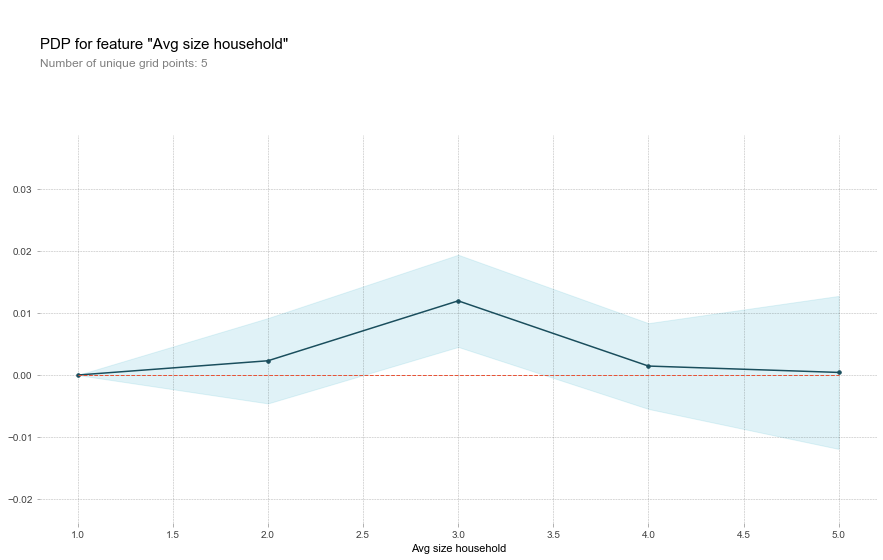

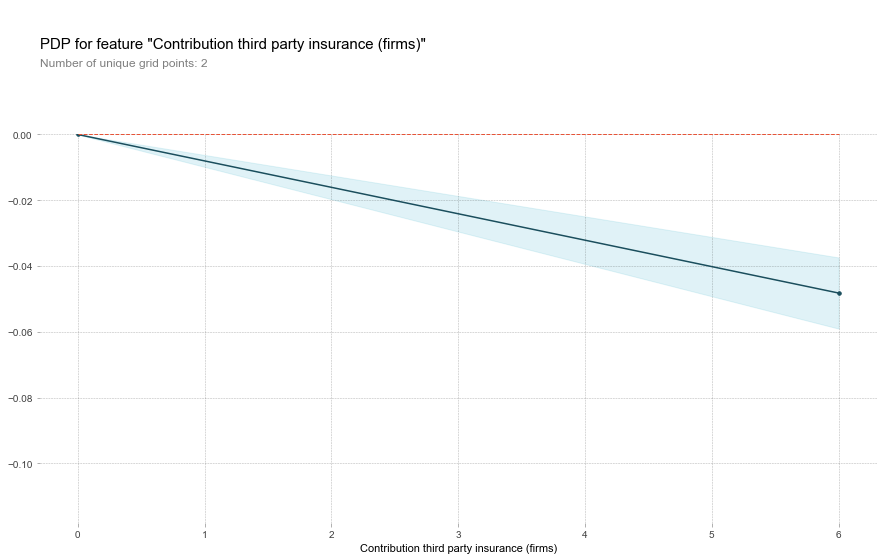

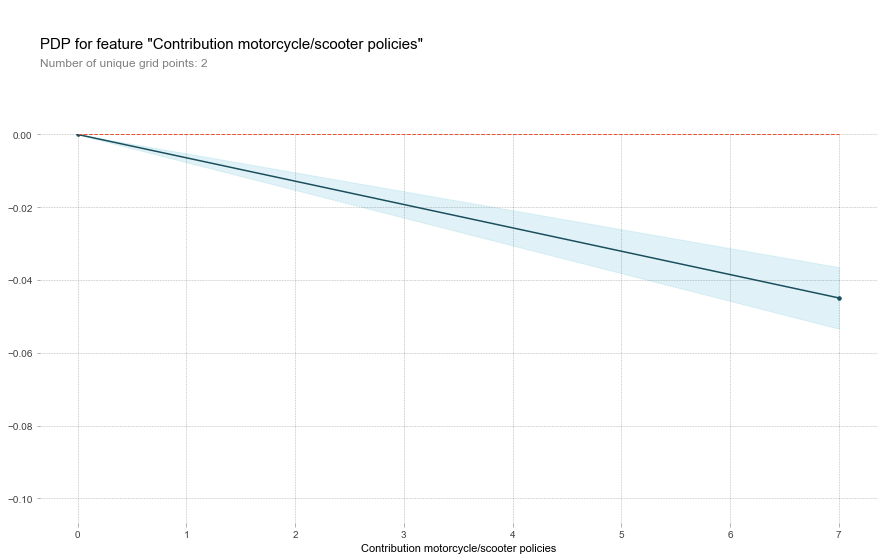

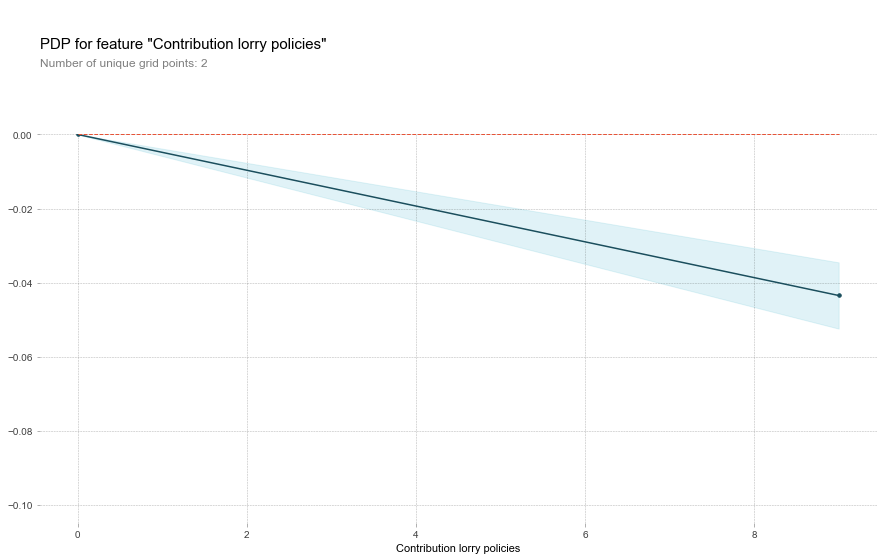

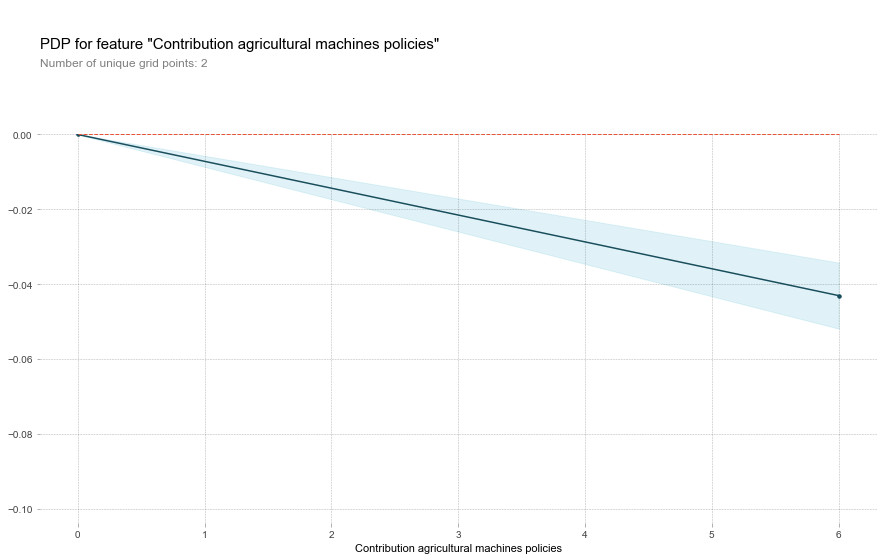

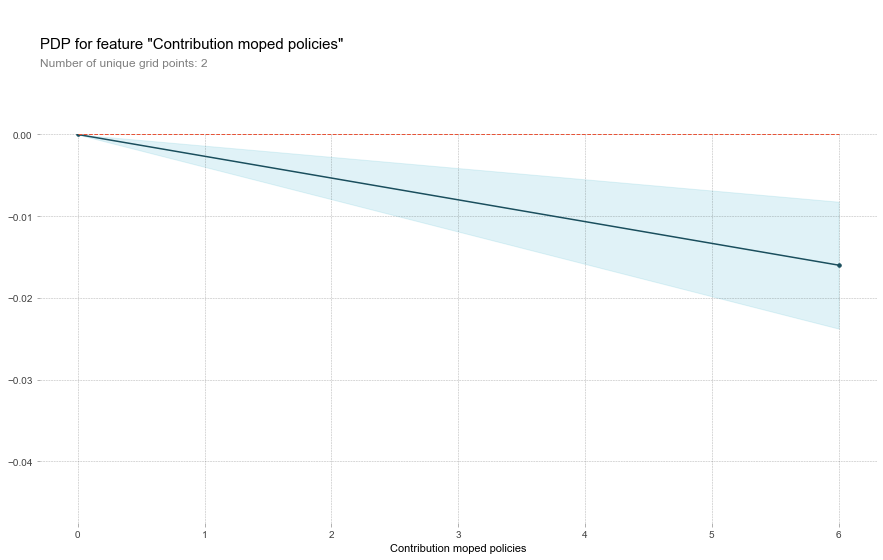

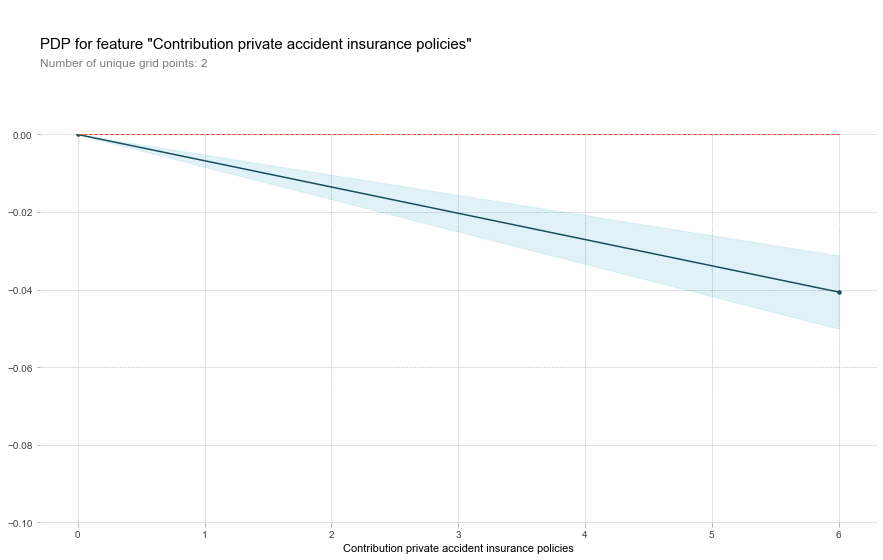

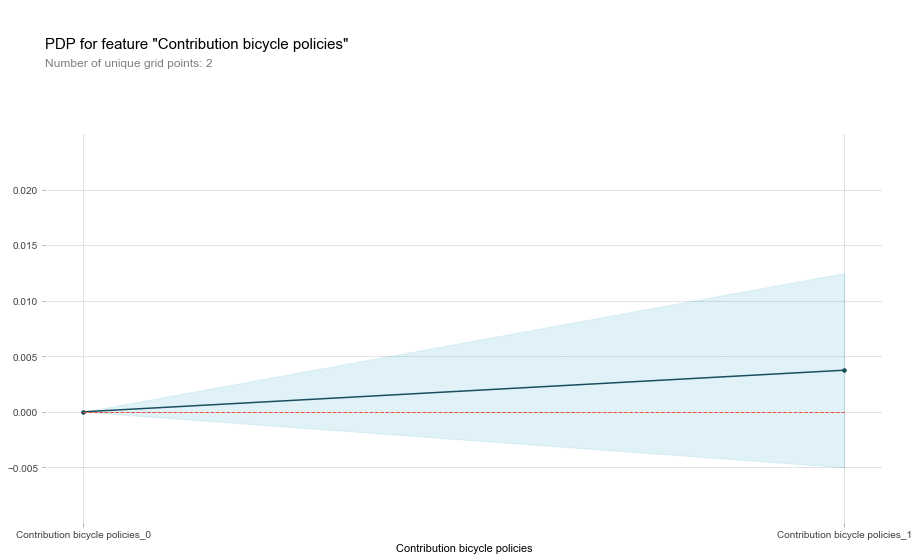

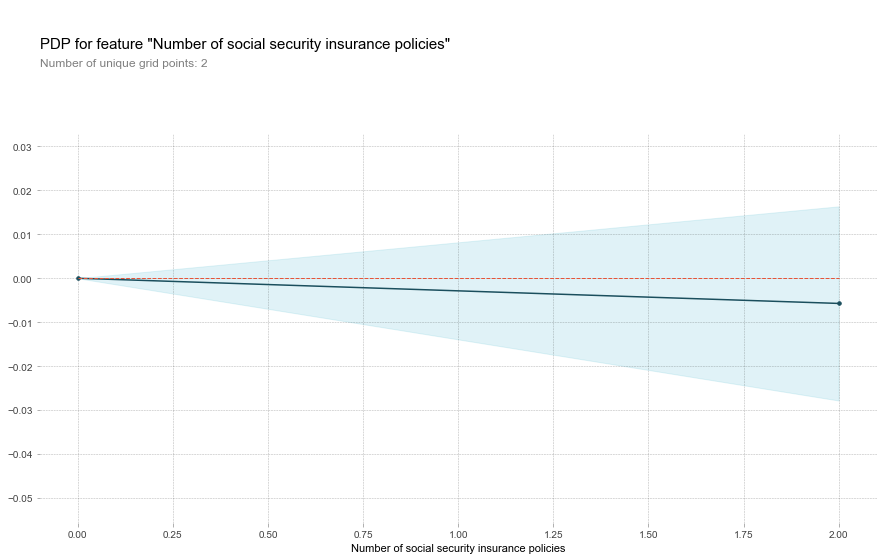

In [8]:
explain_df = X_new.merge(y, left_index=True, right_index=True)


for i in range(10):
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=explain_df, model_features= explain_df.columns[:-1], feature=explain_df.columns[i])

    pdp.pdp_plot(pdp_goals, explain_df.columns[i])
plt.show()

These partial dependence plots explain the 10 selected features and their influence on the likelihood that a customer will end up buying a caravan insurance. 

# Assignment 2

In [9]:
df_test = pd.read_csv('caravanTest.csv')

In [10]:
X_test = df_test[X_new.columns]
y_test = df_test['CARAVAN POLICY']
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      3762
           1       0.06      0.43      0.10       238

    accuracy                           0.56      4000
   macro avg       0.50      0.50      0.41      4000
weighted avg       0.89      0.56      0.68      4000



In [11]:
results = pd.DataFrame(clf.predict_proba(X_test), columns = ['prediction_0', 'prediction_1'])

In [12]:
results['prediction_1'].nlargest(800).index

Int64Index([1726, 3931,  865, 1069, 2128, 3897,   68,  229, 1393, 1760,
            ...
            1749, 1751, 1752, 1754, 1755, 1759, 1764, 1765, 1766, 1767],
           dtype='int64', length=800)

This returns the indices of the 800 candidates with the hightes predicted probability of buying a caravan policy.